# Text Classification: sentiment analysis.

### Data

The dataset we will use of this problem is known as the Stanford Sentiment Treebank. Movie reviews with one sentence per review:
* `sst.bin.*` with binary labels: negative or positive
* `sst.fine.*` with fine-grained labels (very negative, negative, neutral, positive, very positive),

In [124]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from sklearn.linear_model import LogisticRegression
from keras.utils.data_utils import get_file
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils

In [90]:
with open("data/sst.bin.train", "r") as f:
    train = [(int(x.split()[0]), x.split()[1:]) for x in f.readlines()]
with open("data/sst.bin.val", "r") as f:
    val = [(int(x.split()[0]), x.split()[1:]) for x in f.readlines()]
with open("data/sst.bin.test", "r") as f:
    test = [(x.split()[1:]) for x in f.readlines()]
print("Train:     ", len(train), "  Mean sentence length:", np.mean([len(x[1]) for x in train]).round(2))
print("Validation:", len(val))
print("Test:      ", len(test))

Train:      6920   Mean sentence length: 19.3
Validation: 872
Test:       1821


In [91]:
with open("data/sst.bin.train", "r") as f:
    sent_train = [x[2:-1] for x in f.readlines()]
with open("data/sst.bin.val", "r") as f:
    sent_val = [x[2:-1] for x in f.readlines()]
with open("data/sst.bin.test", "r") as f:
    sent_test = [x[2:-1] for x in f.readlines()]

In [108]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [92]:
from collections import Counter, defaultdict
import itertools

# calculate word frequencies
word_frequencies = Counter(itertools.chain(
    *((word for word in sample[1]) for sample in train)
))

Vocabulary size: 14828


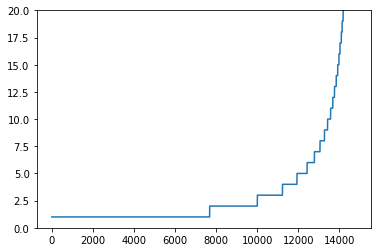

In [60]:
print("Vocabulary size:", len(word_frequencies))

plt.plot([x[1] for x in word_frequencies.most_common()[::-1]])
plt.ylim(0, 20);

In [61]:
# indexing words
PAD = 0 # padding
UNK = 1 # unknown word
vocab = dict()

word_index = 2
for w, c in word_frequencies.most_common():
    if c > 4:
        vocab[w] = word_index
        word_index += 1

In [62]:
# change words with indices

train_X = [[vocab.get(x, UNK) for x in sample[1]]
                    for sample in train]
train_y = [sample[0] for sample in train]

max_len = np.sort([len(x) for x in train_X])

val_X = [[vocab.get(x, UNK) for x in sample[1]]
                    for sample in val]
val_y = [sample[0] for sample in val]

In [63]:
train_X = keras.preprocessing.sequence.pad_sequences(train_X, value=PAD)
train_y = np.array(train_y)

val_X = keras.preprocessing.sequence.pad_sequences(val_X, value=PAD)
val_y = np.array(val_y)

In [64]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((6920, 52), (6920,), (872, 47), (872,))

In [164]:
from keras import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
import keras.backend as K
from keras.layers import Lambda
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten

In [66]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(word_index, embedding_vecor_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          92416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 145,717
Trainable params: 145,717
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=10, batch_size=64)

Train on 6920 samples, validate on 872 samples
Epoch 1/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.6558 - acc: 0.5895 - val_loss: 0.5475 - val_acc: 0.7408
Epoch 2/10
6920/6920 [==============================] - 16s 2ms/step - loss: 0.4508 - acc: 0.7919 - val_loss: 0.4838 - val_acc: 0.7672
Epoch 3/10
6920/6920 [==============================] - 16s 2ms/step - loss: 0.3485 - acc: 0.8509 - val_loss: 0.5330 - val_acc: 0.7626
Epoch 4/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.2884 - acc: 0.8795 - val_loss: 0.5712 - val_acc: 0.7764
Epoch 5/10
6920/6920 [==============================] - 19s 3ms/step - loss: 0.2461 - acc: 0.8999 - val_loss: 0.6313 - val_acc: 0.7741
Epoch 6/10
6920/6920 [==============================] - 17s 2ms/step - loss: 0.2229 - acc: 0.9120 - val_loss: 0.6438 - val_acc: 0.7695
Epoch 7/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.1901 - acc: 0.9234 - val_loss: 0.7258 - val_acc: 0.7523
Epoch 8/

<img src="img/rnn_converge.jpg" style="height: 400px;"/>

## Assignment

Now it is your turn to build the models.
I ask that you construct the following models:

1. A naive Bayes unigram classifer (follow Wang and Manning http://www.aclweb.org/anthology/P/P12/P12-2.pdf#page=118: you should only implement Naive Bayes, not the combined classifer with SVM).
2. A logistic regression model over word types (you can implement this as $y = \sigma(\sum_i W x_i + b)$) 
3. A continuous bag-of-word neural network with embeddings (similar to CBOW in Mikolov et al https://arxiv.org/pdf/1301.3781.pdf).
4. A simple convolutional neural network (any variant of CNN as described in Kim http://aclweb.org/anthology/D/D14/D14-1181.pdf).
5. Your own extensions to these models...

[this](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/) will be useful
<br>
You can also use pretrained word vectors (https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec)


Consult the papers provided for hyperparameters. 

<h3>Implementation</h3>
<h4>Naive Bayes</h4>

In [154]:
def naive_b(X_train, y_train, X_val):
    y_val = np.zeros(X_val.shape[0])
    for i, cont in enumerate(X_val):
        p0 = 1
        p1 = 1
        for word in cont:
            if word>20: #basically taking out words like 'the'
                p0 *= (X_train[y_train == 0] == word).sum()/(y_train==0).sum()
                p1 *= (X_train[y_train == 1] == word).sum()/(y_train==1).sum()
        if p1>p0:
            y_val[i] = 1
    return y_val

naive_b_pred= naive_b(train_X, train_y, val_X)

print("The Accuracy on validation of Naive Bayes is", np.around(accuracy_score(naive_b_pred, val_y)*100, 2), "%")

The Accuracy on validation of Naive Bayes is 77.98 %


<h4>Logistic Regression</h4>

In [157]:
def log_reg(train, val, train_y):
    #imports the vectorizer
    vecorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                                encoding='latin-1', ngram_range=(1, 2), 
                                stop_words='english')
    vecorizer.fit_transform(train + val)
    #extracts features
    feat_train = vecorizer.transform(train).toarray()
    feat_val = vecorizer.transform(val).toarray()
    #puts them into log regression
    log_reg = LogisticRegression()
    log_reg.fit(feat_train, train_y)
    #predicts
    log_pred = log_reg.predict(feat_val)
    return log_pred

log_pred = log_reg(sent_train, sent_val, train_y)

print("The Accuracy score on validation of Log Regression is", np.around(accuracy_score(log_pred, val_y)*100,2), "%")

The Accuracy score on validation of Log Regression is 76.61 %


/home/nitrov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<h4>CBOW</h4>

In [133]:
vocab_size = len(word_frequencies)
embed_size = embedding_vecor_length
window_size = 2

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [145]:
with open("data/sst.bin.train", "r") as corpus:
    corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    corpus = tokenizer.texts_to_sequences(corpus)

In [147]:
corpus = corpus[:300]

In [149]:
for epoch in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, vocab_size):
        loss += cbow.train_on_batch(x, y)

    print(epoch, loss)

0 51513.95791769028
1 48134.76326853037
2 46267.807652533054
3 45518.01332694292
4 45064.4727230072
5 44704.04887408018
6 44378.961128652096
7 44082.23743212223
8 43816.06518089771
9 43579.768104970455


<h4>Simple Convolution Net + LSTM</h4>

In [181]:
embedding_vecor_length = 64
conv_model = Sequential()
conv_model.add(Embedding(word_index, embedding_vecor_length))
conv_model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
conv_model.add(MaxPool1D(pool_size = 2))
conv_model.add(LSTM(100))
conv_model.add(Dense(1, activation='sigmoid'))
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, None, 64)          184832    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 64)          20544     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 271,477
Trainable params: 271,477
Non-trainable params: 0
_________________________________________________________________
None


In [182]:
conv_model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=20, batch_size=64)

Train on 6920 samples, validate on 872 samples
Epoch 1/20
6920/6920 [==============================] - 15s 2ms/step - loss: 0.6347 - acc: 0.6066 - val_loss: 0.5077 - val_acc: 0.7592
Epoch 2/20
6920/6920 [==============================] - 10s 2ms/step - loss: 0.3896 - acc: 0.8277 - val_loss: 0.4806 - val_acc: 0.7752
Epoch 3/20
6920/6920 [==============================] - 11s 2ms/step - loss: 0.2758 - acc: 0.8899 - val_loss: 0.5585 - val_acc: 0.7706
Epoch 4/20
6920/6920 [==============================] - 10s 1ms/step - loss: 0.2200 - acc: 0.9127 - val_loss: 0.5861 - val_acc: 0.7546
Epoch 5/20
6920/6920 [==============================] - 12s 2ms/step - loss: 0.1534 - acc: 0.9397 - val_loss: 0.6788 - val_acc: 0.7798
Epoch 6/20
6920/6920 [==============================] - 12s 2ms/step - loss: 0.0973 - acc: 0.9653 - val_loss: 0.8023 - val_acc: 0.7683
Epoch 7/20
6920/6920 [==============================] - 12s 2ms/step - loss: 0.0679 - acc: 0.9760 - val_loss: 0.9265 - val_acc: 0.7672
Epoch 8/

<h4>Custom Extensions</h4>
<h5>More Complex ConvNet + LSTM</h5>

In [246]:
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Dense, BatchNormalization
from keras.models import Input, Model

embedding_vecor_length = 64
conv_lstm = Sequential()
conv_lstm.add(Embedding(word_index, embedding_vecor_length))
conv_lstm.add(Conv1D(filters = 256, kernel_size = 2, padding = 'same', activation = 'relu'))
conv_lstm.add(MaxPool1D(pool_size = 2))
conv_lstm.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
conv_lstm.add(MaxPool1D(pool_size = 2))
conv_lstm.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
conv_lstm.add(MaxPool1D(pool_size = 2))
conv_lstm.add(Dropout(0.4))
conv_lstm.add(Conv1D(filters = 32, kernel_size = 8, padding = 'same', activation = 'relu'))
conv_lstm.add(MaxPool1D(pool_size = 2))
conv_lstm.add(Dropout(0.4))
conv_lstm.add(Conv1D(filters = 16, kernel_size = 10, padding = 'same', activation = 'relu'))
conv_lstm.add(MaxPool1D(pool_size = 2))
conv_lstm.add(LSTM(100))
conv_lstm.add(Dense(1, activation='sigmoid'))
conv_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(conv_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, None, 64)          184832    
_________________________________________________________________
conv1d_146 (Conv1D)          (None, None, 256)         33024     
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, None, 256)         0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, None, 128)         98432     
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, None, 128)         0         
_________________________________________________________________
conv1d_148 (Conv1D)          (None, None, 64)          41024     
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, None, 64)          0         
__________

In [247]:
conv_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=20, batch_size=64)

Train on 6920 samples, validate on 872 samples
Epoch 1/20
6920/6920 [==============================] - 16s 2ms/step - loss: 0.6915 - acc: 0.5175 - val_loss: 0.6761 - val_acc: 0.5092
Epoch 2/20
6920/6920 [==============================] - 7s 1ms/step - loss: 0.5334 - acc: 0.7259 - val_loss: 0.4896 - val_acc: 0.7672
Epoch 3/20
6920/6920 [==============================] - 7s 1ms/step - loss: 0.3453 - acc: 0.8519 - val_loss: 0.4821 - val_acc: 0.7787
Epoch 4/20
6920/6920 [==============================] - 8s 1ms/step - loss: 0.2680 - acc: 0.8906 - val_loss: 0.5182 - val_acc: 0.7683
Epoch 5/20
6920/6920 [==============================] - 7s 1ms/step - loss: 0.2208 - acc: 0.9159 - val_loss: 0.5129 - val_acc: 0.7764
Epoch 6/20
6920/6920 [==============================] - 7s 1ms/step - loss: 0.1728 - acc: 0.9354 - val_loss: 0.5616 - val_acc: 0.7752
Epoch 7/20
6920/6920 [==============================] - 8s 1ms/step - loss: 0.1414 - acc: 0.9474 - val_loss: 0.6492 - val_acc: 0.7649
Epoch 8/20
692